In [33]:
from arcticdb import Arctic
from arcticdb.toolbox.library_tool import KeyType
import pandas as pd
from arcticdb.version_store._normalization import FrameData
from arcticdb_ext.version_store import AtomKey, PythonOutputFrame, RefKey
from arcticdb_ext.codec import decode_segment
import graphviz
import os
from IPython.display import display, HTML
from datetime import datetime
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

In [34]:
ac = Arctic("lmdb://test_5")
ac.delete_library("vel_test")
lib = ac.get_library("vel_test", create_if_missing=True)
lib_tool = lib._nvs.library_tool()
for sym in range(5):
    sym_name = f"sym_{sym}"
    for i in range(10):
        df = pd.DataFrame({"data": [i]}, index=[pd.Timestamp.now()])
        prune = i % 3 == 0
        lib.append(sym_name, df, metadata={"version": i}, prune_previous_versions=prune)
    for i in range(5):
        df = pd.DataFrame({"data": [i]}, index=[pd.Timestamp.now()])
        lib.append(sym_name, df, metadata={"version": i})
    lib.delete(sym_name, 12)
    lib.update(sym_name, pd.DataFrame({"data": [123]}, index=[pd.Timestamp.now()]))

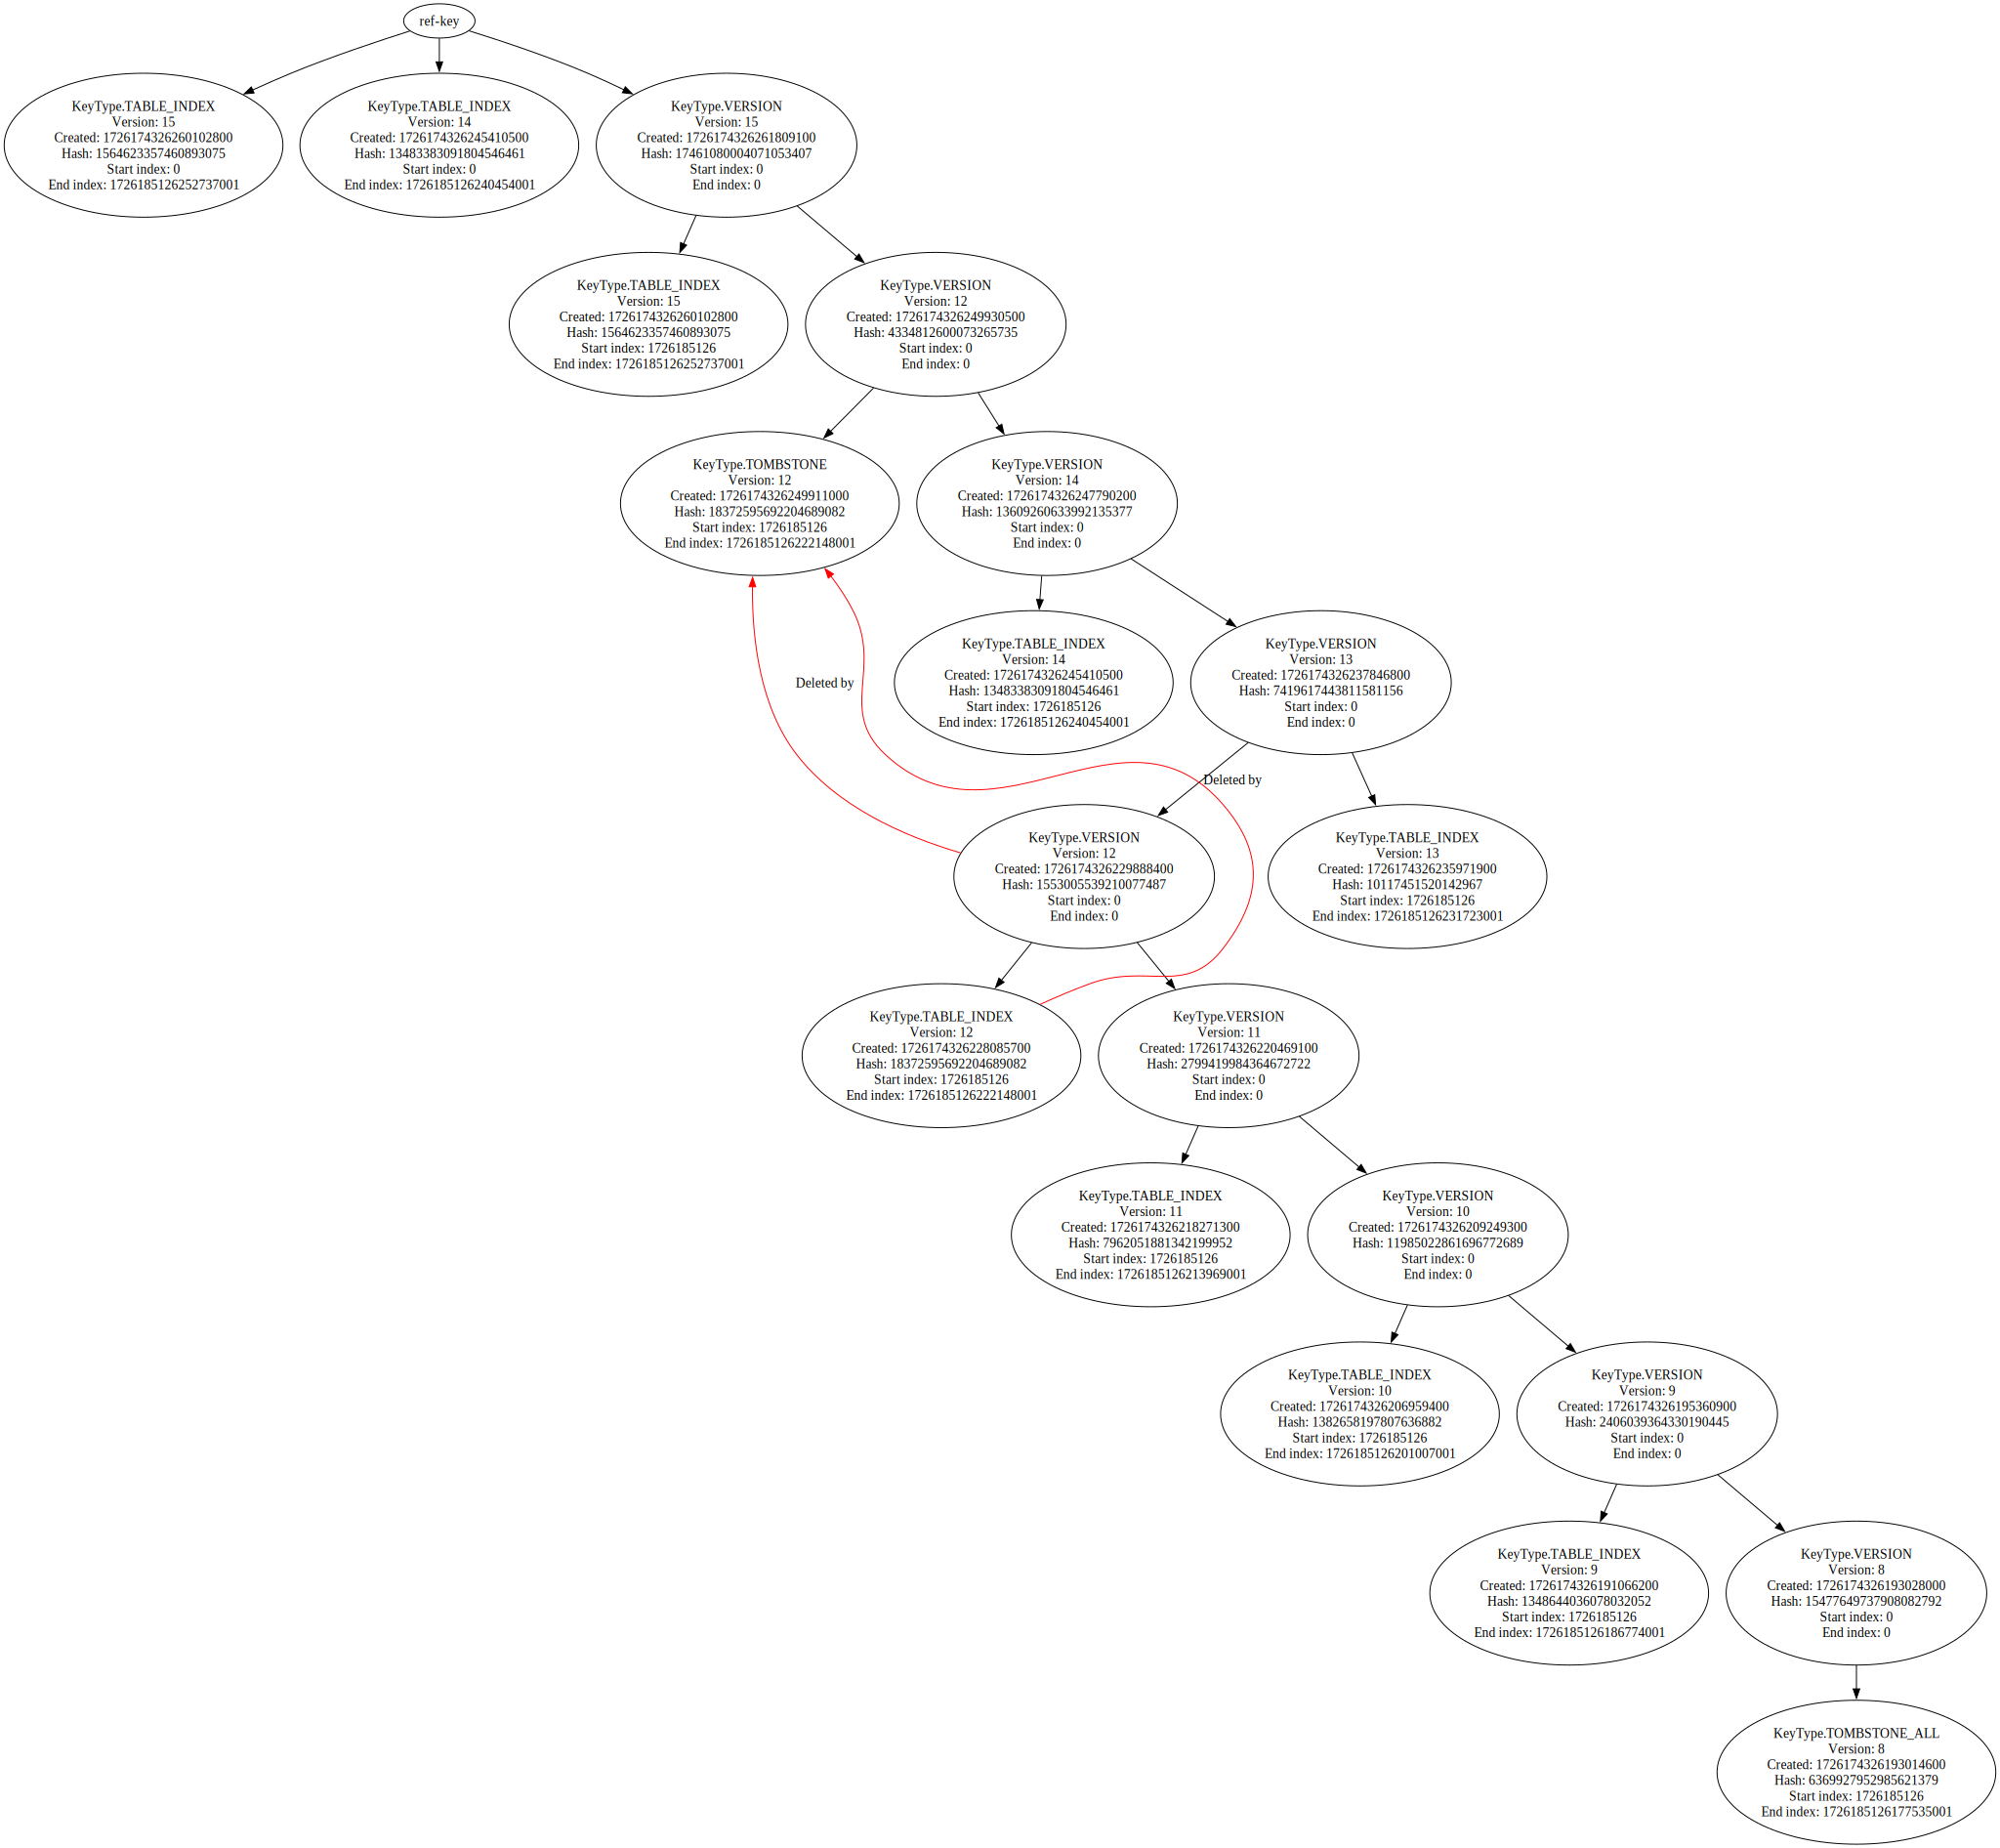

In [37]:
def read_key_to_df(lib_tool, key):
    segment = lib_tool.read_to_segment(key)
    field_names = segment.fields()
    frame_data = FrameData.from_cpp(PythonOutputFrame(decode_segment(segment)))
    cols = {}
    for idx, field_name in enumerate(field_names):
        cols[field_name] = frame_data.data[idx]
    return pd.DataFrame(cols, columns=field_names, index=pd.DatetimeIndex([i for i in range(0, len(frame_data.data[0]))]))
    
def read_ref_key_to_df(lib_tool, symbol):
    key = lib_tool.find_keys_for_symbol(KeyType.VERSION_REF, symbol)[0]
    return read_key_to_df(lib_tool, key)

def tombstone_like(key):
    return key.type in [KeyType.TOMBSTONE, KeyType.TOMBSTONE_ALL]

def create_tag(key):
    return f"{key.content_hash}-{key.version_id}-{key.creation_ts}-{key.start_index}-{key.end_index}"

def create_label(key):
    return f"{key.type}\nVersion: {key.version_id}\nCreated: {key.creation_ts}\nHash: {key.content_hash}\nStart index: {key.start_index}\nEnd index: {key.end_index}"

def traverse_version_chain(lib_tool, symbol, stop_on_first_tombstone_all=False):
    chain = graphviz.Digraph('version-chain')
    ref_df = read_ref_key_to_df(lib_tool, "sym_0")
    chain.node('ref-key')
    keys = [('ref-key', k) for k in lib_tool.dataframe_to_keys(ref_df, symbol)]
    deleted_versions = {}
    tombstone_all = None
    while len(keys) > 0:
        (parent_tag, current_key) = keys.pop(0)
        current_key_tag = create_tag(current_key)
        chain.node(current_key_tag, create_label(current_key))
        chain.edge(parent_tag, current_key_tag)
        if not tombstone_like(current_key):
            if current_key.version_id in deleted_versions:
                chain.edge(current_key_tag, deleted_versions[current_key.version_id], label="Deleted by", color="red", constraint='false')
            elif tombstone_all and current_key.version_id <= tombstone_all.version_id:
                chain.edge(current_key_tag, create_tag(tombstone_all), label="Deleted by", color="red", constraint='false')
        if current_key.type == KeyType.VERSION:
            for key in lib_tool.read_to_keys(current_key):
                keys.append((current_key_tag, key))
                if key.type == KeyType.TOMBSTONE:
                    deleted_versions[key.version_id] = create_tag(key)
                elif key.type == KeyType.TOMBSTONE_ALL:
                    tombstone_all = key;
                    if stop_on_first_tombstone_all:
                        break
    return chain

traverse_version_chain(lib_tool, "sym_0", stop_on_first_tombstone_all=True)

    
    
        